In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import apra_pop_models
from apra_pop_models.math_module import xp, _scipy, ensure_np_array
import apra_pop_models.fresnel_coro_2dm_34 as fresnel
import apra_pop_models.rmad_2dm as rmad
import apra_pop_models.utils as utils
import apra_pop_models.props as props
from apra_pop_models.imshows import imshow1, imshow2, imshow3

import lina
import lina.adefc as adefc
from scipy.optimize import minimize


/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models


/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models


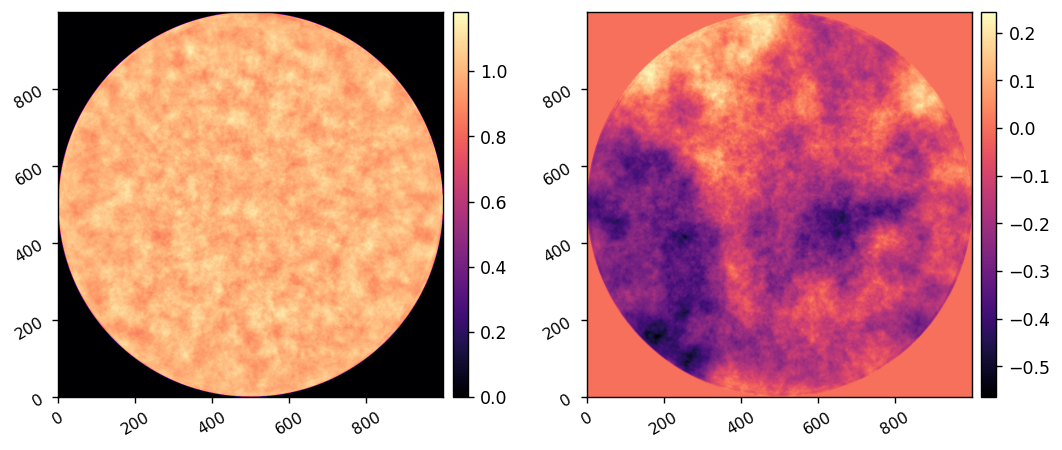

In [2]:
reload(fresnel)
M = fresnel.CORO()
M.use_opds = True

WFE = M.calc_pupil()
imshow2(xp.abs(WFE), xp.angle(WFE))

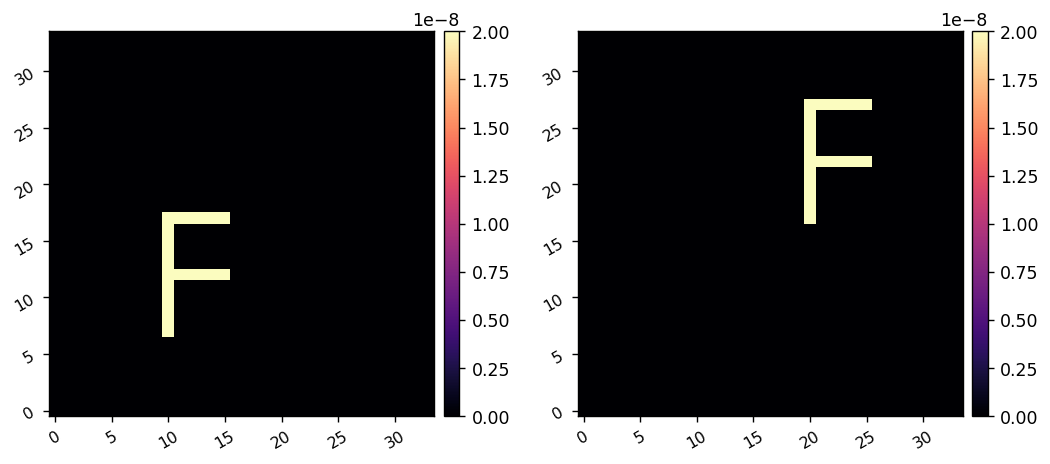

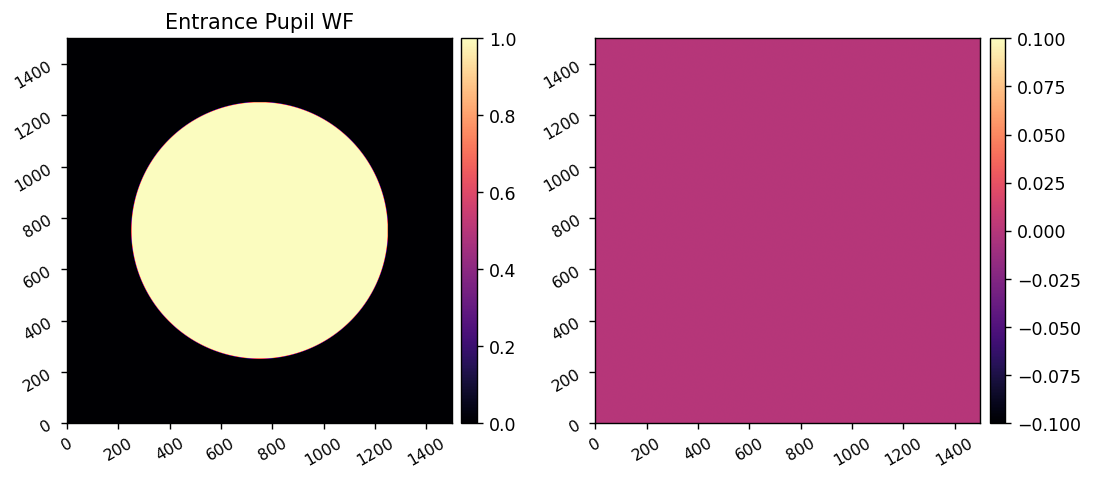

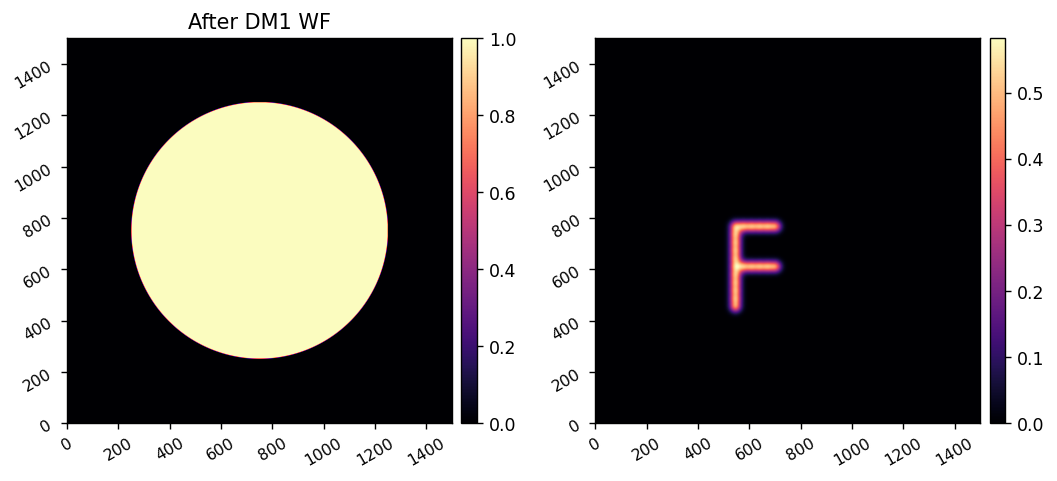

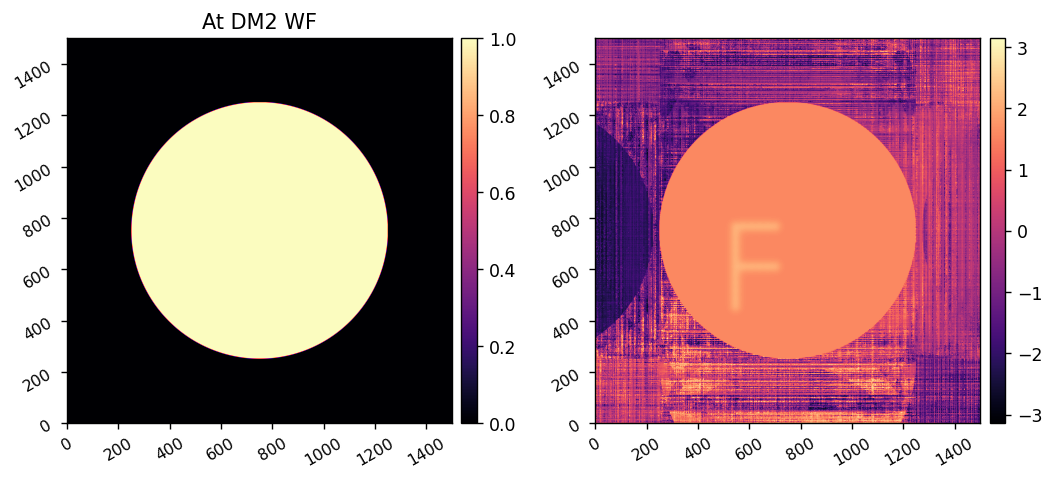

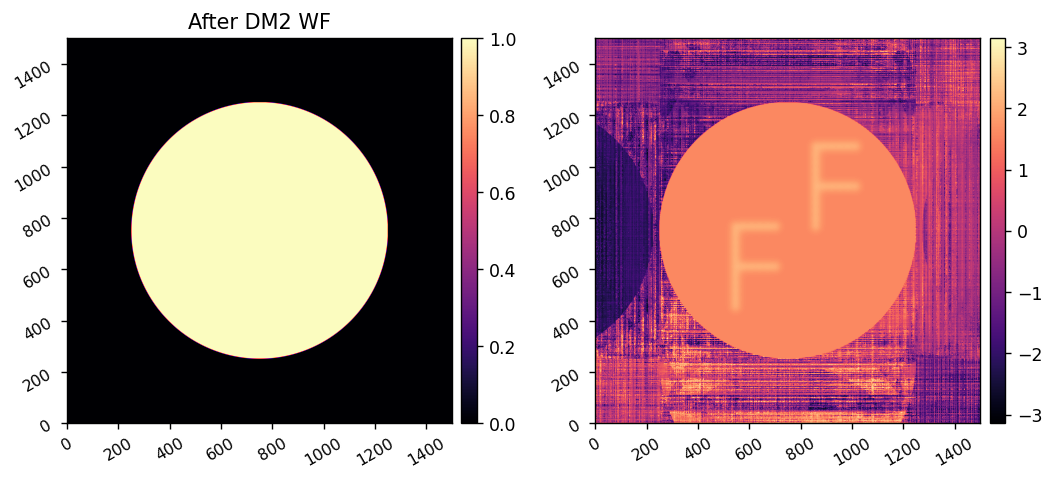

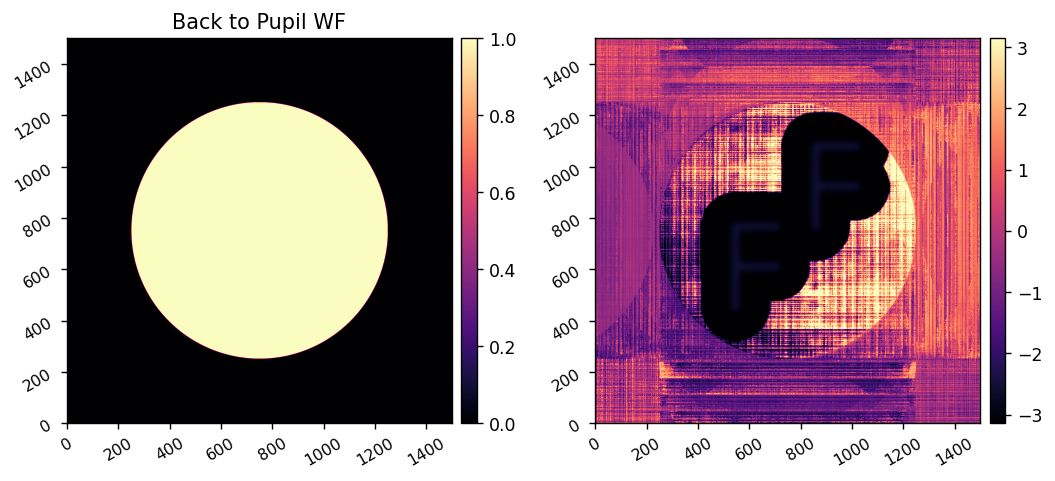

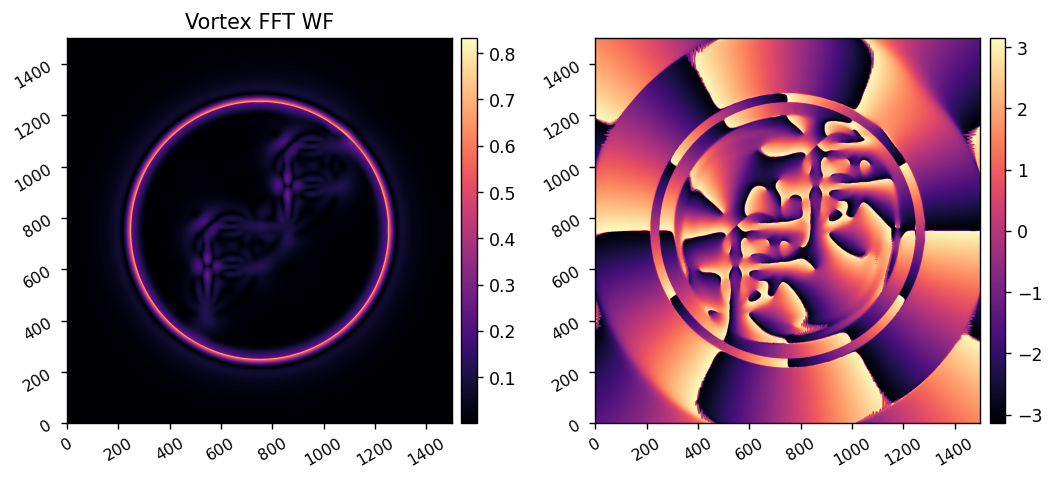

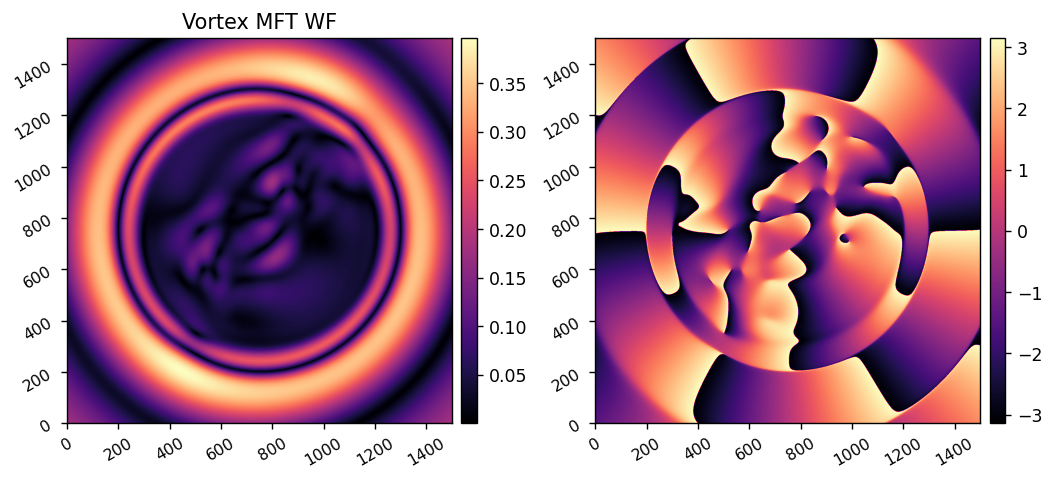

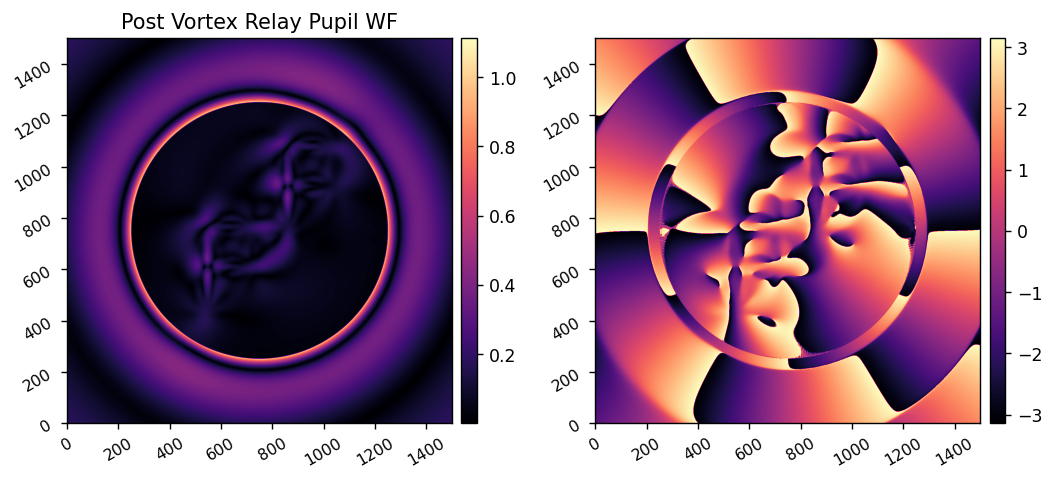

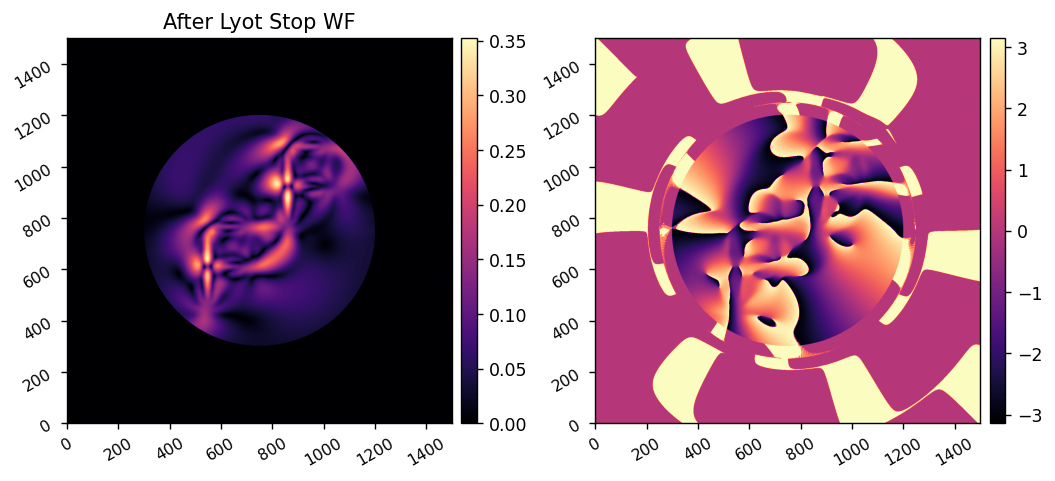

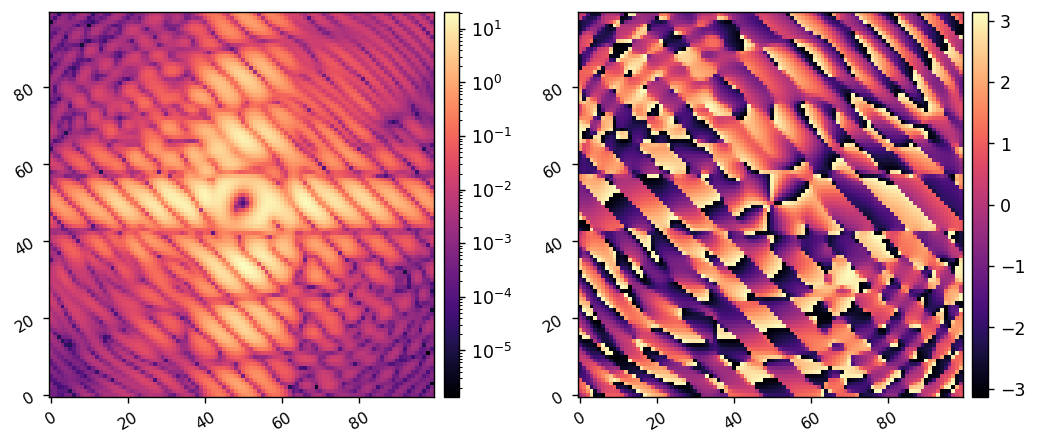

In [3]:
reload(rmad)
reload(lina.utils)
M = rmad.MODEL()
# M.WFE = WFE
# M.flip_dm = True

dm1 = xp.zeros((M.Nact, M.Nact))
dm2 = xp.zeros((M.Nact, M.Nact))

dm1 = 20e-9 * lina.utils.make_f(h=10, w=6, shift=(-5,-5))
dm2 = 20e-9 * lina.utils.make_f(h=10, w=6, shift=(5,5))
imshow2(dm1, dm2)

acts = xp.concatenate([dm1[M.dm_mask], dm2[M.dm_mask]])
fpwf = M.forward(acts, use_vortex=True, plot=True)

In [21]:
dm1 = xp.zeros((M.Nact, M.Nact))
dm2 = xp.zeros((M.Nact, M.Nact))
acts = xp.concatenate([dm1[M.dm_mask], dm2[M.dm_mask]])

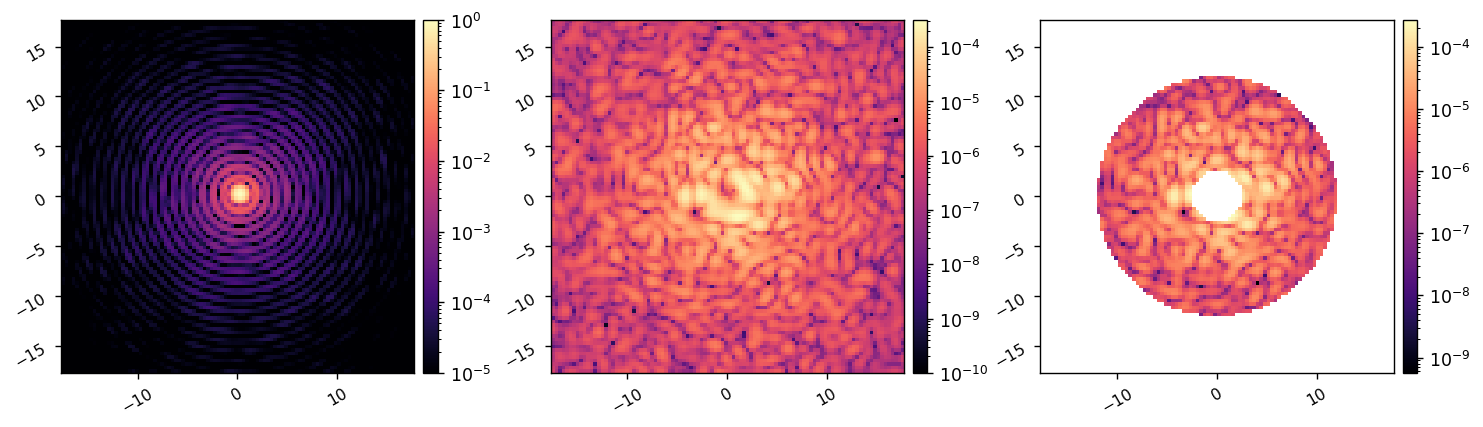

In [14]:
reload(rmad)
reload(props)
M = rmad.MODEL()
M.WFE = WFE

M.zero_dms()
iwa = 2.5
owa = 12
rot = 0
control_mask = lina.utils.create_annular_focal_plane_mask(M.npsf, M.psf_pixelscale_lamD, irad=iwa, orad=owa, edge=None, rotation=rot)

M.use_vortex = False
ref_psf = M.snap()
M.Imax_ref = xp.max(ref_psf)
ref_psf /= M.Imax_ref
M.use_vortex = True
ref_coro_im = M.snap()

imshow3(ref_psf, ref_coro_im, ref_coro_im*control_mask, 
        pxscl=M.psf_pixelscale_lamD, lognorm=True, vmin1=1e-5, vmin2=1e-10)


	Cost-function J_delE: 0.038
	Cost-function J_c: 0.000
	Cost-function normalization factor: 0.038
	Total cost-function value: 1.000



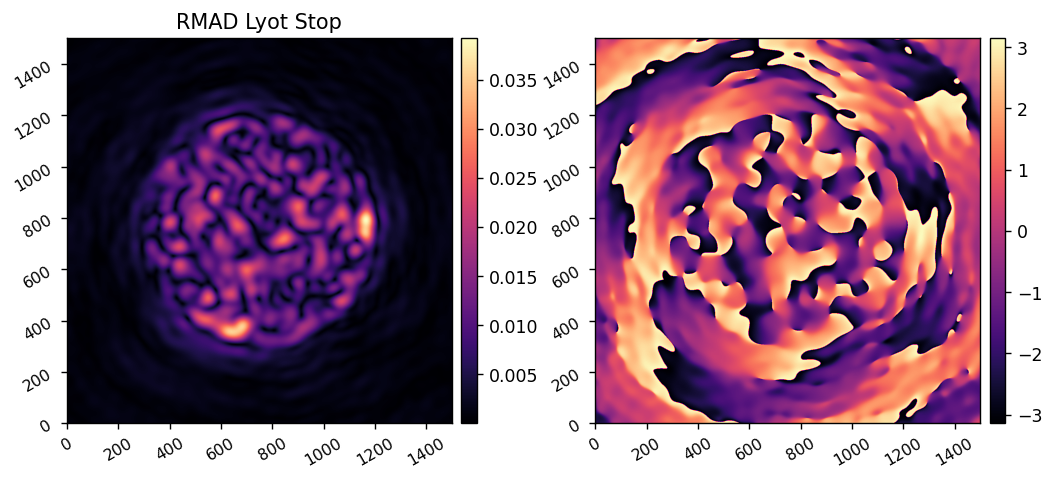

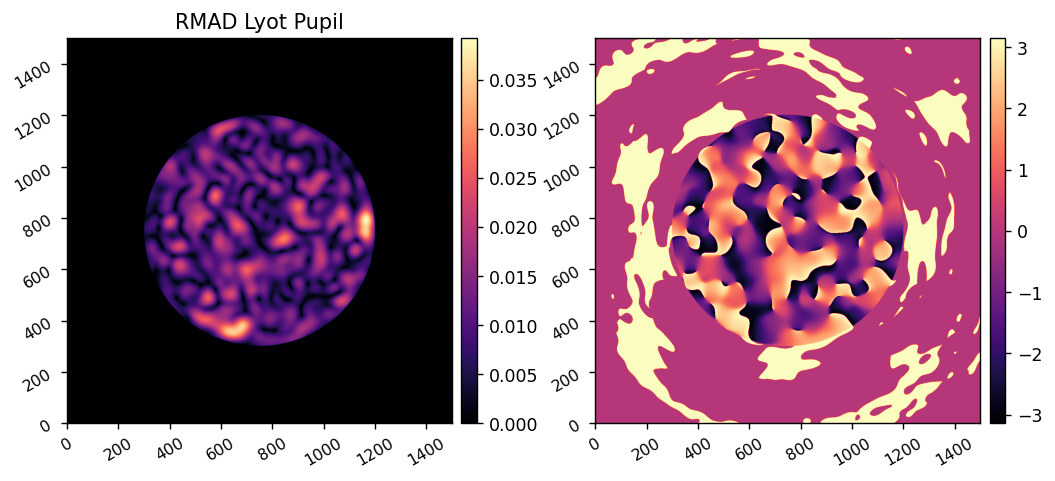

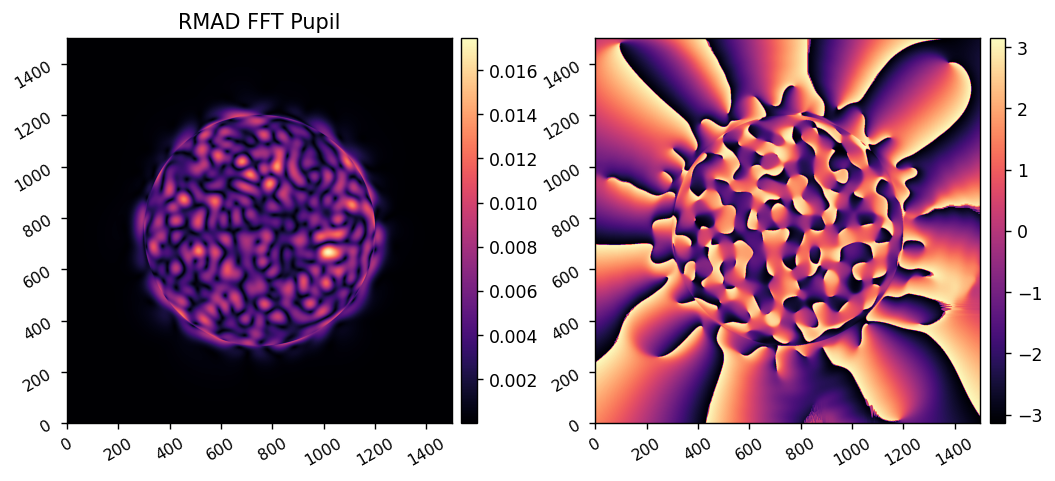

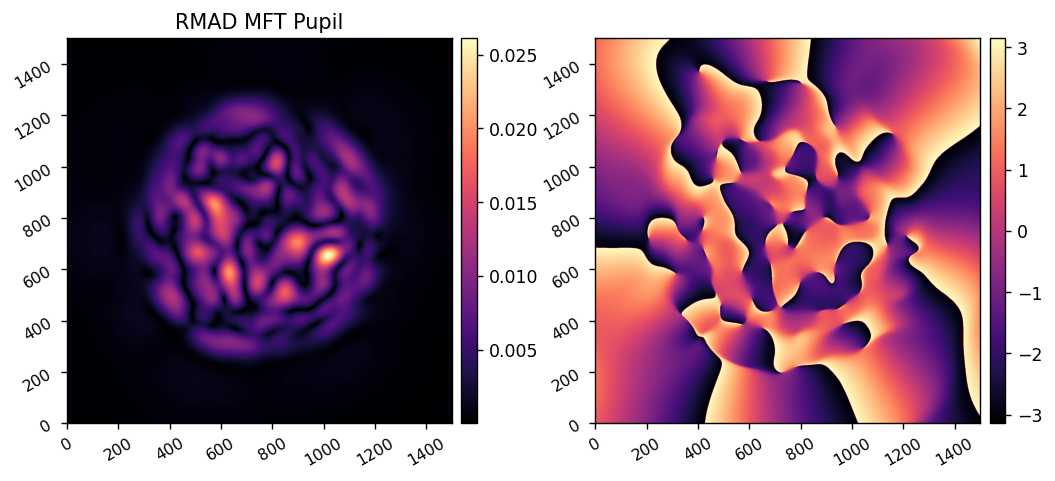

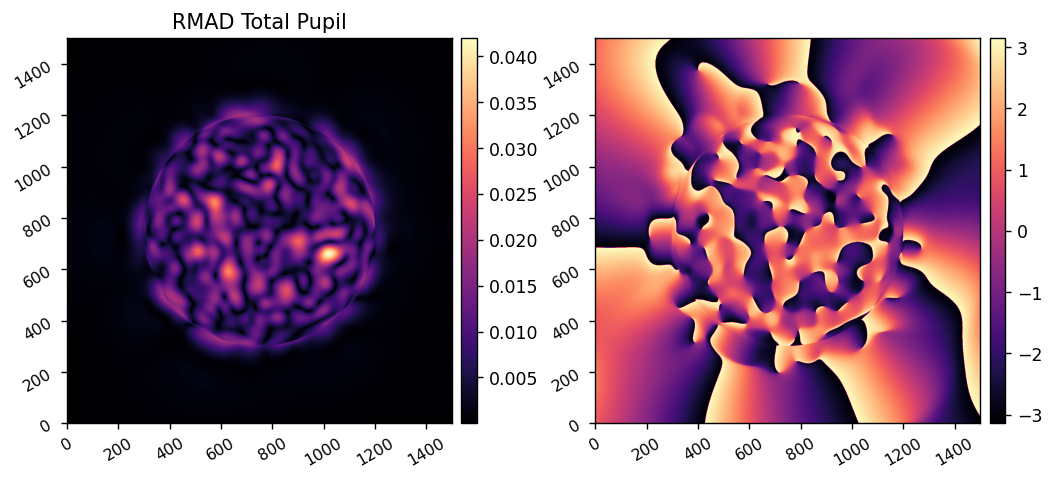

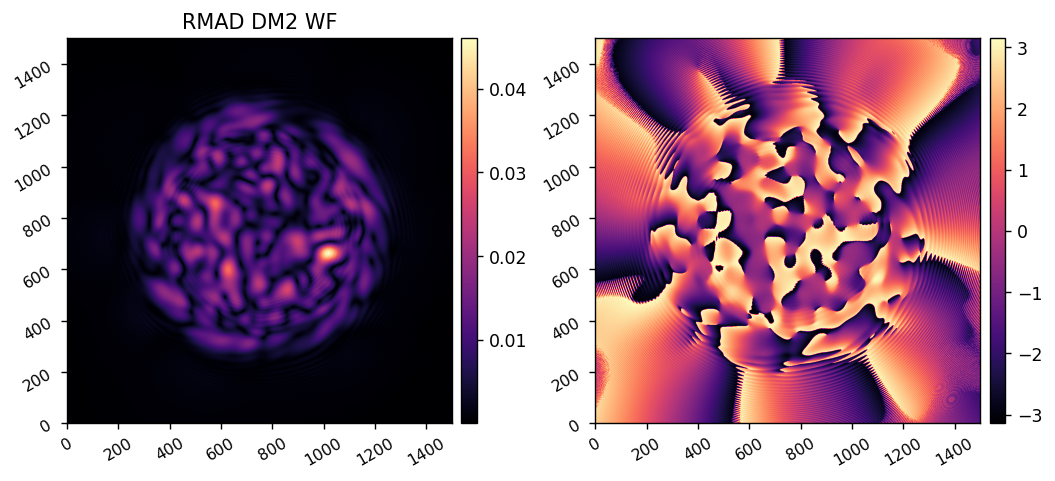

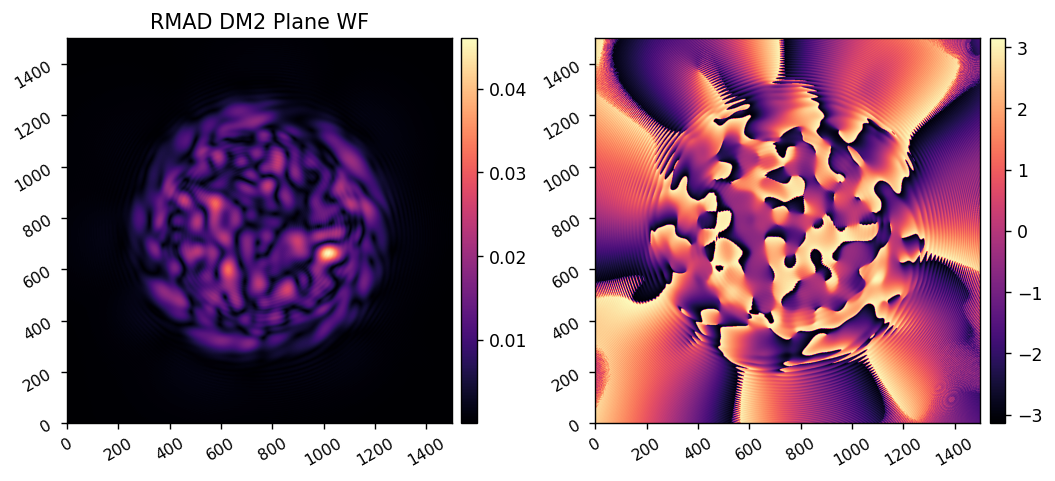

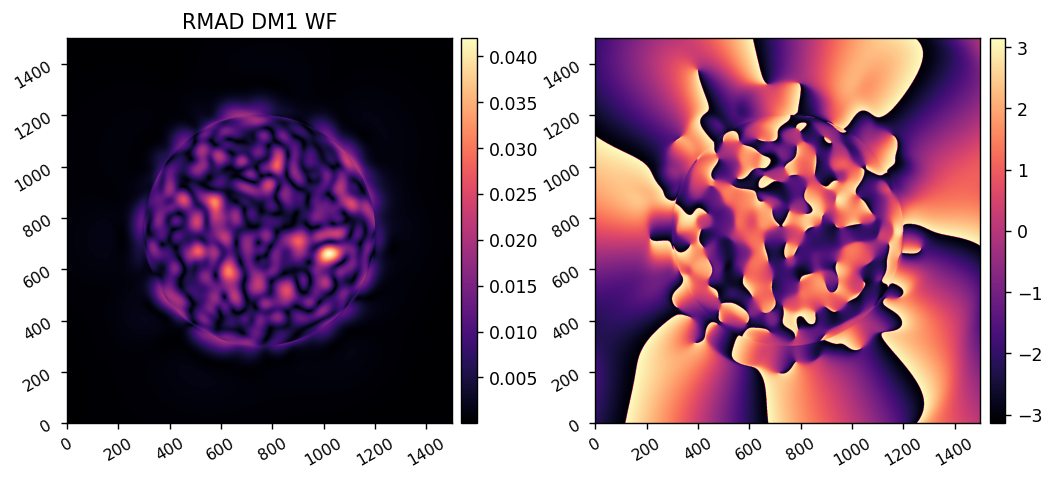

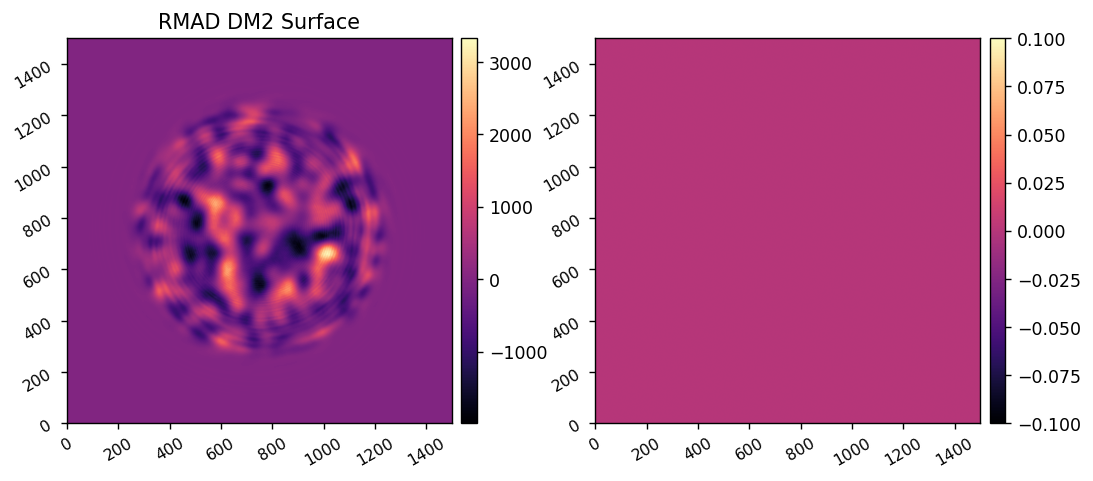

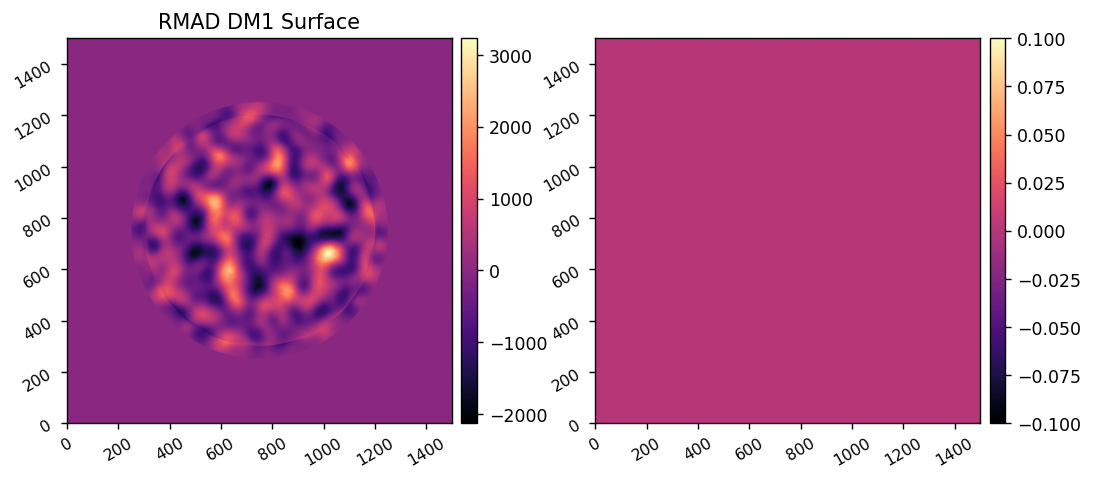

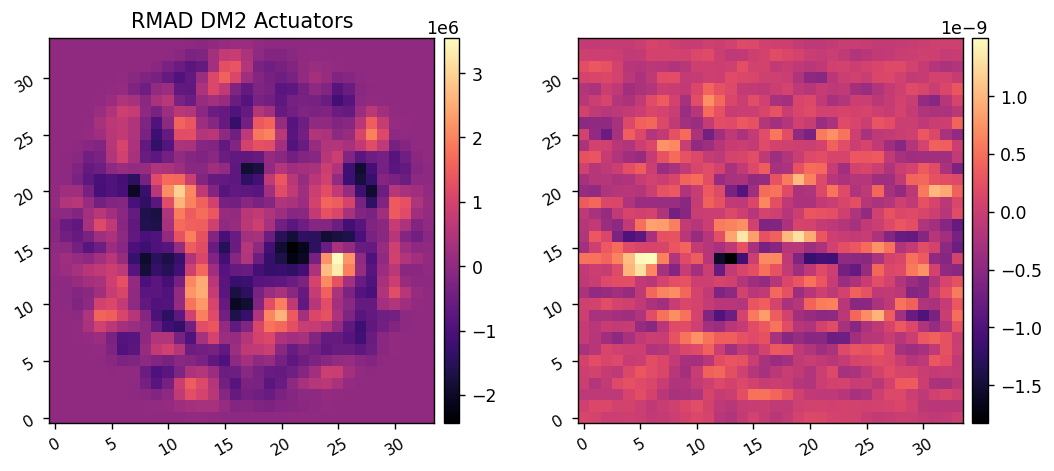

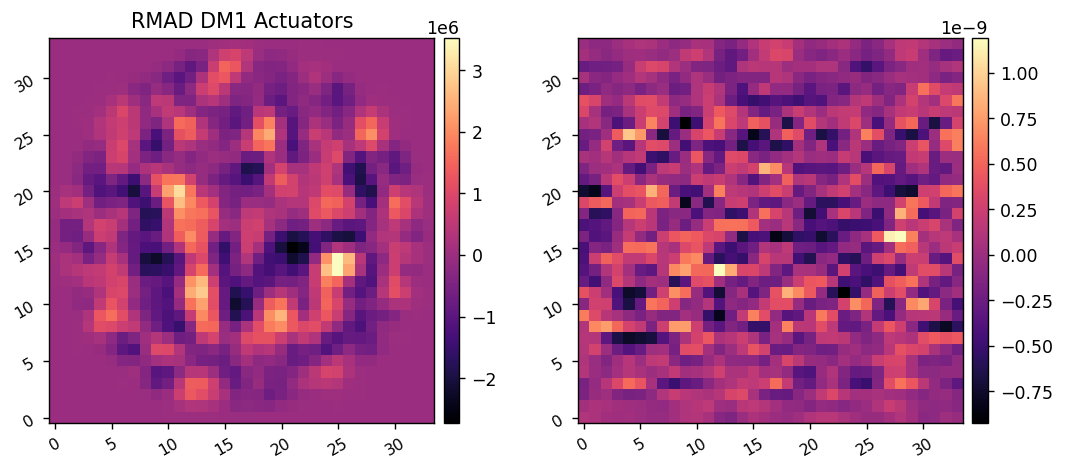

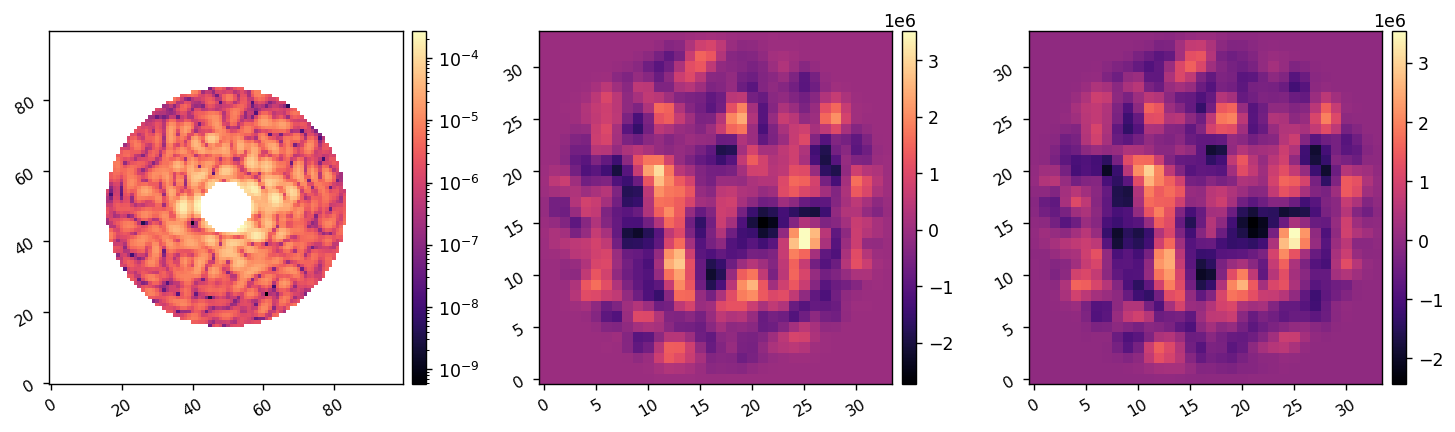

In [15]:
reload(rmad)

acts = xp.zeros(M.Nacts)
# acts = fits.getdata('example-data/ad_test_acts.fits')

M.set_dm1(rmad.acts_to_command(acts[:M.Nacts//2], M.dm_mask))
M.set_dm2(rmad.acts_to_command(acts[M.Nacts//2:], M.dm_mask))
E_ab = M.calc_wf() * control_mask
r_cond = 1e-2

del_acts = np.zeros(M.Nacts)
J, dJ_dA = rmad.val_and_grad(del_acts, M, acts, E_ab, r_cond, control_mask, verbose=True, plot=True)

dm1_grad = rmad.acts_to_command(dJ_dA[:M.Nacts//2], M.dm_mask)
dm2_grad = rmad.acts_to_command(dJ_dA[M.Nacts//2:], M.dm_mask)
imshow3(xp.abs(E_ab)**2, dm1_grad, dm2_grad, lognorm1=True)